In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
%matplotlib inline

2023-09-08 09:28:59.708712: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 09:28:59.734948: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 09:28:59.735408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 09:29:00.261682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow import keras
from tensorflow.keras import models, layers, callbacks, activations, optimizers

In [16]:
def data_arrays(data_path):
    dataset = h5py.File(data_path, 'r')
    x_train = np.array(dataset['X_train']).transpose([0,2,1])
    y_train = np.array(dataset['Y_train'])
    x_valid = np.array(dataset['X_valid']).transpose([0,2,1])
    y_valid = np.array(dataset['Y_valid'])
    x_test = np.array(dataset['X_test']).transpose([0,2,1])
    y_test = np.array(dataset['Y_test'])
    alphabet = 'ACGT'

    
    return x_train, y_train, x_valid, y_valid, x_test, y_test, alphabet


In [17]:
x_train, y_train, x_valid, y_valid, x_test, y_test, alphabet = data_arrays(data_path= '/home/pgarcia/rbp_project/data/HNRNPK_K562_200.h5')
print(x_train.shape, y_train.shape)

(4008, 200, 9) (4008, 1)


In [33]:
def input_shape_check(x_train, x_test,x_valid):
    if x_train.shape[-1] == 4:
        print("Input shape is correct: " + x_train.shape)
    else:
        # Adjust input shape
        x_train = x_train[:,:,:4]
        x_test = x_test[:,:,:4]
        x_valid = x_valid[:,:,:4]

        # Print the shape of the training data
        print("Input shape adjusted:")
        print(x_train.shape)
        print(x_test.shape)
        print(x_valid.shape)
    return x_train, x_test, x_valid

In [38]:
x_train, x_test, x_valid = input_shape_check(x_train, x_test,x_valid)

Input shape adjusted:
(4008, 200, 4)
(1146, 200, 4)
(572, 200, 4)


In [5]:
#check initial input shape
print(x_train.shape)

#Adjust input shape
x_train = x_train[:,:,:4]
x_test = x_test[:,:,:4]
x_valid = x_valid[:,:,:4]

# Print the shape of the training data
print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

(4008, 200, 9)
(4008, 200, 4)
(1146, 200, 4)
(572, 200, 4)


In [35]:
y_test#checks whether classification or regression task

array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]], dtype=int8)

In [39]:
def deepbind_test():
    #Build the model
    model = models.Sequential()
    #layer1
    model.add(layers.InputLayer(input_shape=(200, 4))) # 4 channel input
    #layer2
    model.add(layers.Conv1D(filters=16, kernel_size=24, padding='same'))
    model.add(layers.Activation(activations.relu))
    #layer3
    model.add(layers.MaxPooling1D(pool_size=25))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(units=32, activation='relu')) #model says "one hidden layer with 32 ReLu units"?
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(units=1, activation='sigmoid'))
    

    
    print(model.summary())
    
    
    return model

In [40]:
model = deepbind_test()
loss = keras.losses.BinaryCrossentropy()
opti = tf.keras.optimizers.Adam(learning_rate = 0.005)

# Compile the model
model.compile(
    loss=loss, 
    optimizer=opti, 
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", name="auroc"),
        tf.keras.metrics.AUC(curve="PR", name="aupr")  # add AUPR curve to track dataset bias
    ]
    ) 

# Define an early stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model
model.fit(
    x_train, y_train, 
    batch_size=100, 
    epochs=100, 
    validation_data=(x_valid, y_valid),
    callbacks=[es_callback]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 200, 16)           1552      
                                                                 
 activation_2 (Activation)   (None, 200, 16)           0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 8, 16)             0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                      

In [9]:
#evaluate the model
model.evaluate(x_test, y_test)

36/36 [==============================] - 0s 979us/step - loss: 0.2820 - auroc: 0.9712 - aupr: 0.9622


[0.2819617688655853, 0.9711576104164124, 0.9621874094009399]

## Notes

model.add(layers.Dense(units=1, activation='sigmoid')) 

#output layer with condensed layer of 1 bec. we want a predic.

#we want to change the activation function to sigmoid function because our dataset contains a binary classification task

#This is the case bec the data contains a label of "1" if the protein binds or "0" if it does not

## Saliency Maps

In [10]:
#get model predictions for test sequences
predictions = model.predict(x_test)

# Get the top num_plots predictions
num_plots = 10

# Get the sorted indices
sorted_indices = np.argsort(predictions[:, 0])[::-1]

# Extract the top num_plots sequences
X = x_test[sorted_indices[:num_plots]]

# Reshape X to (num_plots, 200, 4)
X = X.reshape((num_plots, 200, 4))

36/36 [==============================] - 0s 721us/step


In [11]:
import tensorflow as tf

@tf.function
def calculate_saliency_map(X, model, class_index=0):
  """fast function to generate saliency maps"""
  if not tf.is_tensor(X):
    X = tf.Variable(X)

  with tf.GradientTape() as tape:
    tape.watch(X)
    output = model(X)[:,class_index]
  return tape.gradient(output, X)

saliency_map = calculate_saliency_map(X, model)
saliency_map = saliency_map.numpy()

/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/pgarcia/.conda/envs/tf_2/lib/python3.9/site-packag

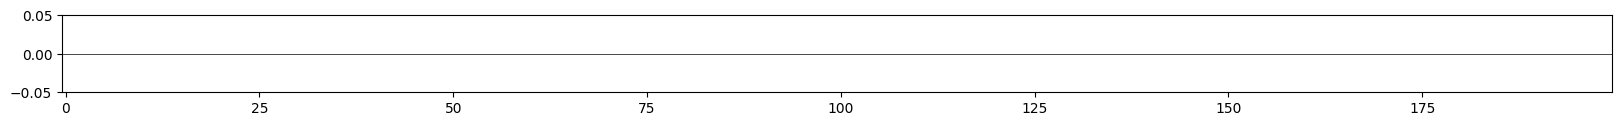

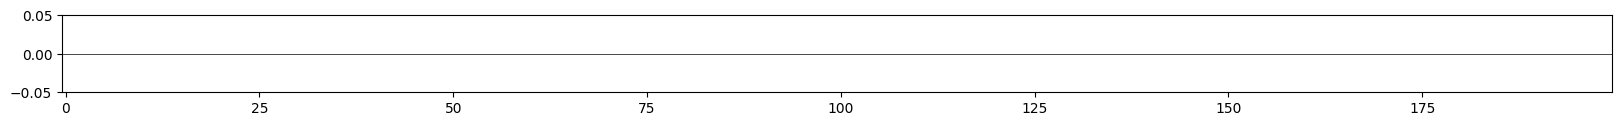

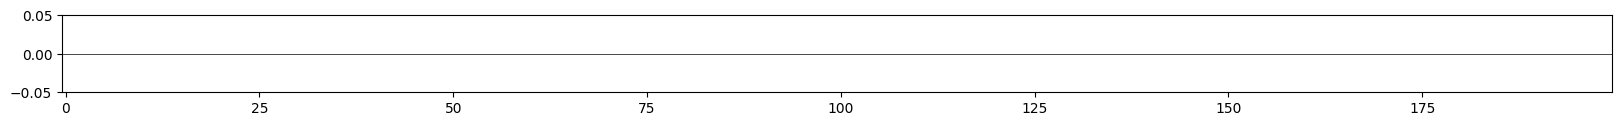

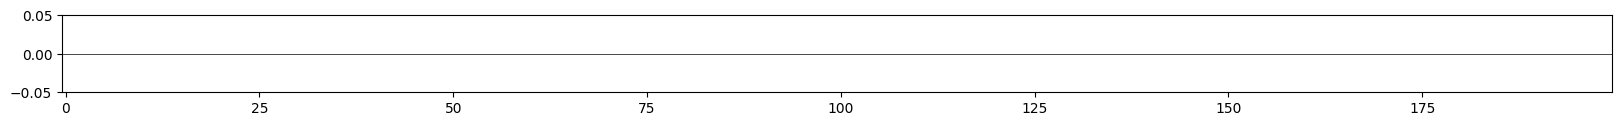

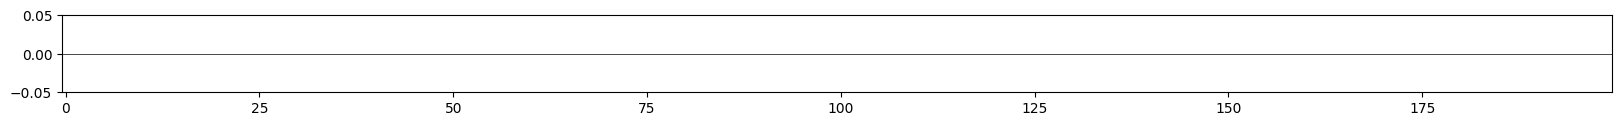

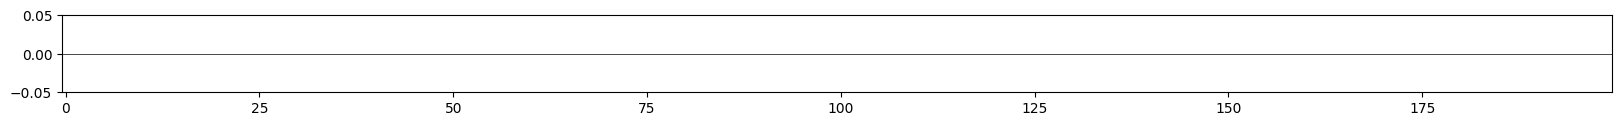

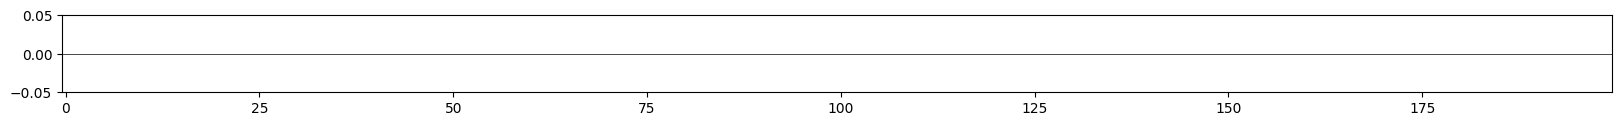

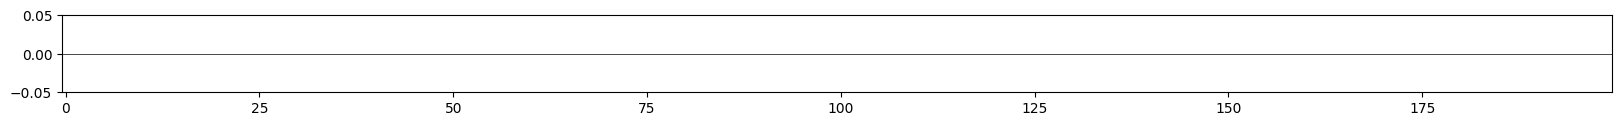

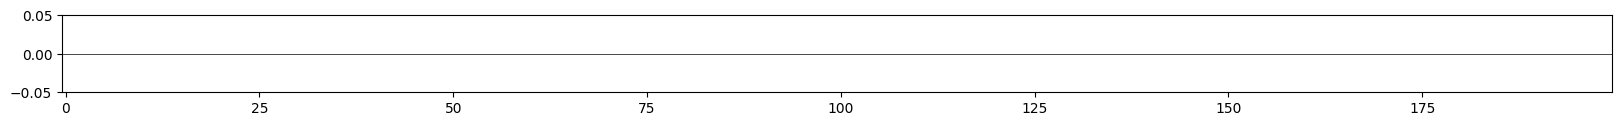

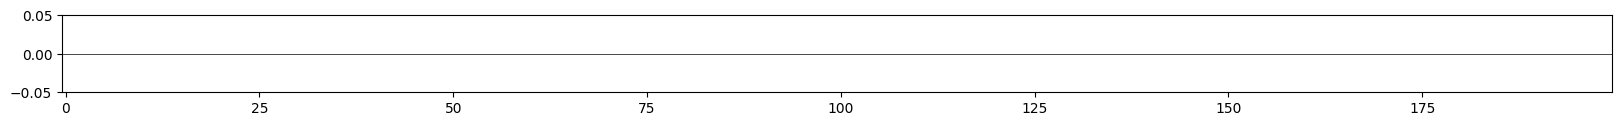

In [12]:
import pandas as pd
import logomaker

def plot_saliency_map(scores, alphabet, ax=None):
  L,A = scores.shape
  counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
  for a in range(A):
    for l in range(L):
      counts_df.iloc[l,a] = scores[l,a]

  if not ax:
    ax = plt.subplot(1,1,1)
  logomaker.Logo(counts_df, ax=ax)


saliency_scores = saliency_map * X
for scores in saliency_scores:
  fig = plt.figure(figsize=(20,1))
  ax = plt.subplot(1,1,1)
  plot_saliency_map(scores, alphabet, ax)

In [ ]:
os.makedirs('/home/pgarcia/rbp_project/models_deepbind')# Creating a directory
model.save('models_deepbind/HNRNPK_K562_200.h5')   # Saving model

In [ ]:
#Implement 2 layer Convol model from "Representation learning of genomic sequence motifs with CNNs" paper
    
#Build the model
model = models.Sequential()
#layer1
model.add(layers.InputLayer(input_shape=(200, 4))) # 4 channel input
#layer2
model.add(layers.Conv1D(filters=30, kernel_size=19, strides= 1, padding='same', kernal_regularizer=1e-6))
model.add(layers.Activation(activations.relu))
#layer3
model.add(layers.MaxPooling1D(pool_size=2, strides=2))
model.add(layers.Dropout(0.1))
    
model.add(layers.Conv1D(filters=128, kernel_size=5, strides= 1, padding='same',  kernal_regularizer=1e-6))
model.add(layers.MaxPooling1D(pool_size=50, strides=50))
model.add(layers.Dropout(0.1))
#model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dropout(0.5))



In [ ]:
def _repre_test():
    #Build the model
    model = models.Sequential()
    #layer1
    model.add(layers.InputLayer(input_shape=(200, 4))) # 4 channel input
    
    #layer2
    #model.add(layers.Conv1D(filters=30, kernel_size=19, strides= 1, padding='same', kernel_regularizer=1e-6))
    #L2_kernelregularizer = tf.keras.regularizers.L2(0.003)
    model.add(layers.Conv1D(filters=30, kernel_size=19, strides= 1, padding='same'))
    # [tf.keras.regularizers.L2(1e-6)]
    model.add(layers.Activation(activations.relu))

    #layer3
    model.add(layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv1D(filters=30, kernel_size=19, strides= 1, padding='same'))
    #model.add(layers.Conv1D(filters=128, kernel_size=5, strides= 1, padding='same',  kernel_regularizer=1e-6))
    model.add(layers.MaxPooling1D(pool_size=50, strides=50))
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(units=512, activation='relu'))
    model.add(layers.Dropout(0.5))
    

    #Compile the model
    loss = keras.losses.BinaryCrossentropy()
    opti = tf.keras.optimizers.Adam(learning_rate = 0.003)
    model.compile(loss=loss, optimizers=opti, metrics=[tf.keras.metrics.AUC(curve="ROC", name="auroc"),tf.keras.metrics.AUC(curve="PR", name="aupr")]) #add AUPR curve to track dataset bias
    #model.add(optimizers.Adam(learning_rate= 0.0003))
    
    #Define an early stopping callback
    es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    

    return model, es_callback

In [ ]:
models

In [ ]:
def repre_test():
    
    #Build the model
    tf.keras.backend.clear_session()
    model = models.Sequential()
    # layer1
    model.add(layers.InputLayer(input_shape=(200, 4))) # 4 channel input
    
    # layer2
    l2_regularizer = tf.keras.regularizers.L2(1e-6)
    model.add(layers.Conv1D(filters=30, kernel_size=19, strides=1, padding='same', kernel_regularizer=l2_regularizer))
    # add batch normalization
    # batch_norm = tf.keras.layers.BatchNormalization()
    model.add(layers.Activation(activations.relu))

    # layer3
    model.add(layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Conv1D(filters=30, kernel_size=19, strides=1, padding='same'))
    # model.add(layers.Conv1D(filters=30, kernel_size=19, strides= 1, padding='same', kernel_regularizer=l2_regularizer))
    model.add(layers.MaxPooling1D(pool_size=50, strides=50))
    model.add(layers.Dropout(0.1))
    model.add(layers.Flatten())
    
    model.add(layers.Dense(units=512, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(units=1, activation='sigmoid'))

    # model.summary()

    
    return model

In [ ]:
#Compile the model
model = repre_test()
loss = keras.losses.BinaryCrossentropy()
opti = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(
    loss=loss, 
    optimizer=opti, 
    metrics=[
        tf.keras.metrics.AUC(curve="ROC", name="auroc"),
        tf.keras.metrics.AUC(curve="PR", name="aupr")
    ]
    ) # add AUPR curve to track dataset bias

# Define an early stopping callback
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(
    x_train, y_train, 
    batch_size=100, 
    epochs=100, 
    validation_data=(x_valid, y_valid),
    callbacks=[es_callback]
)

In [ ]:
#evaluate the model
model.evaluate(x_test, y_test)

In [ ]:
print(y_test.shape)

# Saliency Analysis

In [ ]:
#get model predictions for test sequences
predictions = model.predict(x_test)

# Get the top num_plots predictions
num_plots = 10

# Get the sorted indices
sorted_indices = np.argsort(predictions[:, 0])[::-1]

# Extract the top num_plots sequences
X = x_test[sorted_indices[:num_plots]]

# Reshape X to (num_plots, 200, 4)
X = X.reshape((num_plots, 200, 4))

In [ ]:
import tensorflow as tf

@tf.function
def calculate_saliency_map(X, model, class_index=0):
  """fast function to generate saliency maps"""
  if not tf.is_tensor(X):
    X = tf.Variable(X)

  with tf.GradientTape() as tape:
    tape.watch(X)
    output = model(X)[:,class_index]
  return tape.gradient(output, X)

saliency_map = calculate_saliency_map(X, model)
saliency_map = saliency_map.numpy()

In [ ]:
import pandas as pd
import logomaker

def plot_saliency_map(scores, alphabet, ax=None):
  L,A = scores.shape
  counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
  for a in range(A):
    for l in range(L):
      counts_df.iloc[l,a] = scores[l,a]

  if not ax:
    ax = plt.subplot(1,1,1)
  logomaker.Logo(counts_df, ax=ax)


saliency_scores = saliency_map * X
for scores in saliency_scores:
  fig = plt.figure(figsize=(20,1))
  ax = plt.subplot(1,1,1)
  plot_saliency_map(scores, alphabet, ax)

In [ ]:
#STOP